In [1]:
cd /home/c01muya/vae-disentanglement/disentanglement_lib_pl

/home/c01muya/vae-disentanglement/disentanglement_lib_pl


In [1]:
cd D:\\Saarbrucken\\EDA_Research\\vae-disentanglement\\disentanglement_lib_pl

D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl


In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

from bvae_experiment import BVAEExperiment
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
from common.notebook_utils import *
from common.utils import CenteredNorm
# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})
np.set_printoptions(suppress=True,precision=4)

In [19]:
def model_and_activations(current_device,  dataset, checkpoint_path, activation_type,
                          batch_size=64, beta=1.0, z_dim=10, l_dim=6, num_batches=1):
    
    activations, full_dataset, model = load_model_and_data_and_get_activations(
                        dset_name=dataset, dset_path='../datasets', 
                        batch_size=batch_size, z_dim=z_dim , beta=beta, 
                        checkpoint_path=checkpoint_path, current_device=current_device, 
                        activation_type=activation_type, seed=123,  batches=num_batches, l_zero_reg=False, l_dim=l_dim
        )

    data_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle = False,drop_last=True)

    return model, activations, data_loader

# Correlation 0.2 Beta 2

In [3]:
current_device = torch.device("cuda:3")
dataset='dsprites_full'
checkpoint_path="../train-logs/jscmodel/epoch=25-step=299520.ckpt"

model_and_activations(current_device,  dataset, checkpoint_path)
img, labels = next(dsprites_full_loader.__iter__())
diffs = check_correlated_dimensions(img.to(current_device), model_dsprites_full, current_device)
visualize_change(diffs[0])

Experiment class: cpu
Model class: cpu
Loaded 737280 images


  0%|▏                                                                                                                                                                                                   | 10/10368 [00:01<24:24,  7.07it/s]


# Correlation 0.2 Beta 1

In [6]:
current_device = torch.device("cuda:3")
batch_size = 64
seed = 123
beta = 1.0
z_dim = 10

checkpoint_path="../train-logs/jscmodel_bvae_w1corr02_dsprites/epoch=25-step=299520.ckpt"

acts_for_dsprites_full, dsprites_full_dataset, model_dsprites_full  = load_model_and_data_and_get_activations(
                    dset_name='dsprites_full', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=current_device, 
                    activation_with_label=False, seed=123,  batches=10, l_zero_reg=False
    )

dsprites_full_loader = DataLoader(dsprites_full_dataset, batch_size=batch_size, shuffle = False,drop_last=True)
img, labels = next(dsprites_full_loader.__iter__())
diffs = check_correlated_dimensions(img.to(current_device), model_dsprites_full, current_device)
visualize_change(diffs[0])

Experiment class: cpu
Model class: cpu
Loaded 737280 images


  0%|▏                                                                                                                                                                                                   | 10/10368 [00:00<16:03, 10.75it/s]


# 50 epochs dsprites 0.2 corr beta=1

In [5]:
current_device = torch.device("cuda:0")
dataset='dsprites_correlated'
checkpoint_path="../models/epoch=49-step=576000.ckpt"
os.environ['DISENTANGLEMENT_LIB_DATA'] = '../datasets'

model, activations, data_loader  = model_and_activations(current_device,  dataset, checkpoint_path, l_dim=5, num_batches=200,
                                                        activation_type='for_scatter')

Initialize [CorrelatedDSpritesDataset] with 737280 examples. Shape (737280, 64, 64).


In [48]:
mus, labels = activations

In [49]:
len(mus), len(labels), type(model)

(12800, 12800, bvae_experiment.BVAEExperiment)

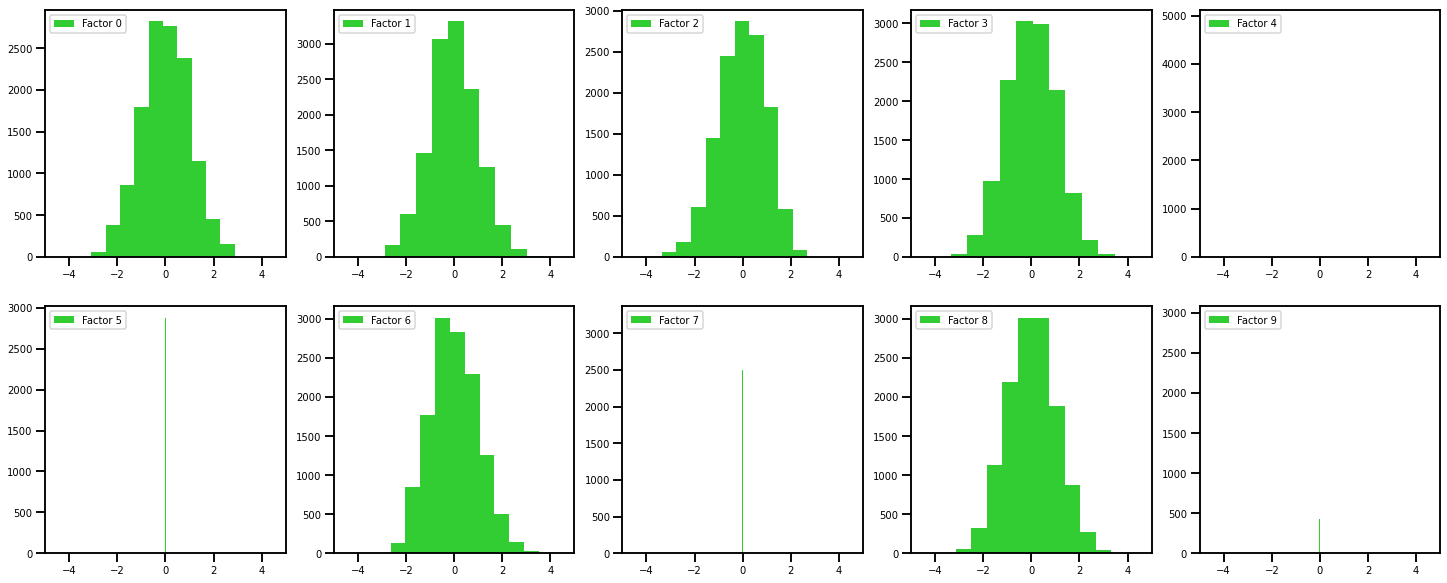

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25,10))
i=0
for r in range(2):
    for c in range(5):
        axes[r,c].hist(mus[:,i], label=f"Factor {i}", color='limegreen')
        axes[r,c].tick_params(axis='both', which='major', labelsize=10)
        axes[r,c].legend(prop={'size': 10}, loc='upper left')
        axes[r,c].set_xlim(-5,5)
        i = i + 1

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

mus, labels = activations
gbt_models = {}
feature_imps = []
train_acc = []
test_acc = []
factors = ["shape", "scale", "orientation", "position x", "position y"]
N = len(mus)
Ntest = 1000 #points for test
T = N - Ntest

for current_factor in range(len(factors)):
    
    X_train, X_test = mus[:T, :], mus[T:, :] 
    y_train, y_test = labels[:T, current_factor], labels[T:, current_factor]

    gbt_models[factors[current_factor]] = GradientBoostingClassifier().fit(X_train, y_train)

    feature_imps.append(gbt_models[factors[current_factor]].feature_importances_.reshape(1, X_train.shape[1]))
    
    train_acc.append(np.mean(gbt_models[factors[current_factor]].predict(X_train) == y_train))
    test_acc.append(np.mean(gbt_models[factors[current_factor]].predict(X_test) == y_test))

[0.8168604651162791, 0.6844186046511628, 0.8196511627906977, 0.8502325581395349, 0.8287209302325581]
[0.76, 0.522, 0.265, 0.396, 0.313]


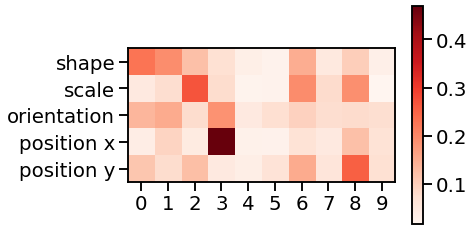

In [9]:
feature_imps_cat =np.concatenate(feature_imps, axis=0)
plt.imshow(feature_imps_cat, cmap='Reds')
plt.colorbar()
yt = plt.yticks(ticks=range(len(factors)), labels=factors)
xt = plt.xticks(ticks=range(10), labels=range(10))
print(train_acc)
print(test_acc)

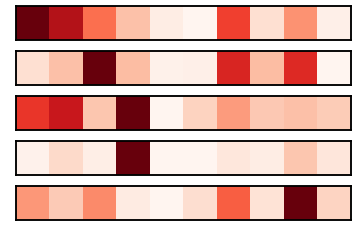

In [10]:
fig, ax = plt.subplots(5,1)
for i in range(5):
    ax[i].imshow(feature_imps_cat[i].reshape(1,10), cmap='Reds')
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

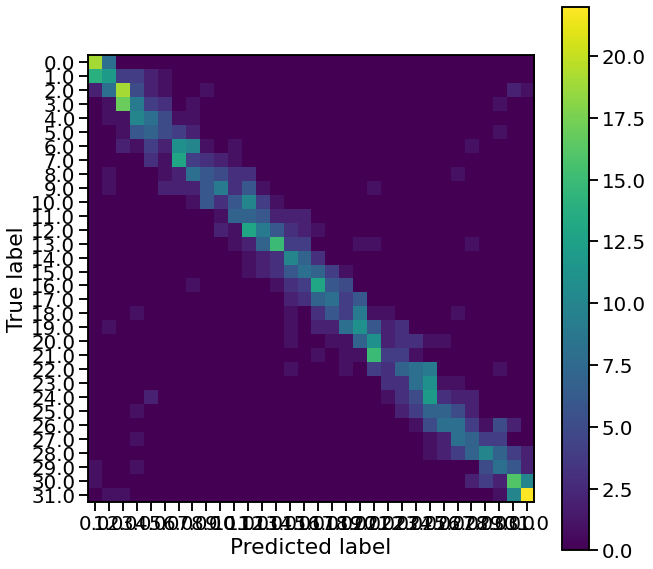

In [13]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(gbt_models['position y'], mus[T:, :], labels[T:, 4], ax=ax, include_values=False)

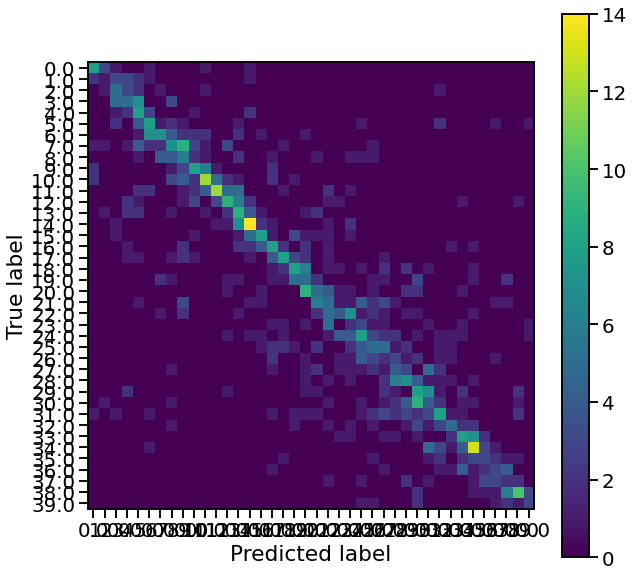

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(gbt_models['orientation'], mus[T:, :], labels[T:, 2], ax=ax, include_values=False)

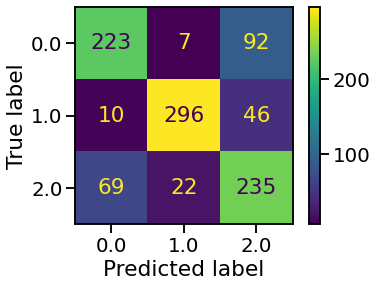

In [14]:
plot_confusion_matrix(gbt_models['shape'], mus[T:, :], labels[T:, 0])

In [59]:
def pairwise_dimension_sactter_plot(mus, labels, xdim, ydim, ldim):
    label_names = ["shape", "scale", "orientation", "position x", "position y"]
    sc = plt.scatter(mus[:, xdim], mus[:, ydim], cmap='YlGn', c=labels[:,ldim], s=5) #, norm=CenteredNorm(), s=3)
    #sc = plt.scatter(mus[:, xdim], mus[:, ydim], cmap='coolwarm', c=labels[:,ldim], s=5, norm=CenteredNorm())
    plt.colorbar(sc)
    plt.xlabel(f"z_{xdim}")
    plt.ylabel(f"z_{ydim}")
    plt.title(f'Pairwise wrt {label_names[ldim]}')

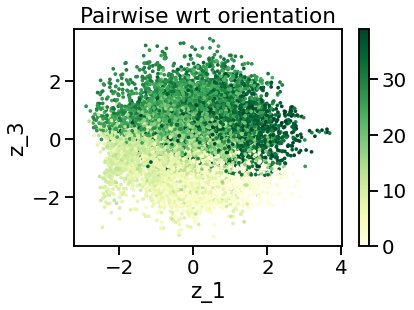

In [68]:
pairwise_dimension_sactter_plot(mus, labels, xdim=1, ydim=3, ldim=2)

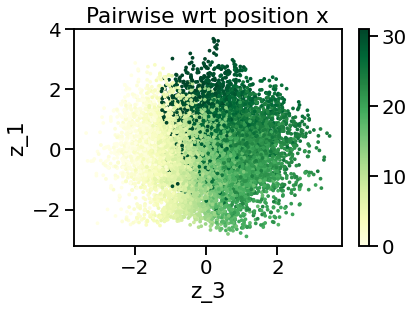

In [74]:
pairwise_dimension_sactter_plot(mus, labels, xdim=3, ydim=1, ldim=3)

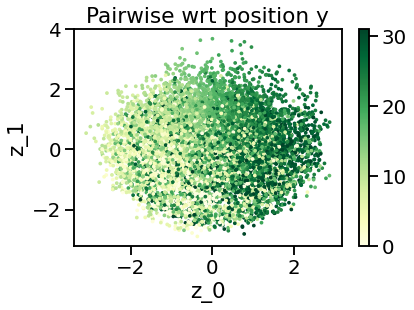

In [73]:
pairwise_dimension_sactter_plot(mus, labels, xdim=0, ydim=1, ldim=4)

In [10]:
imgs, labels = next(data_loader.__iter__())

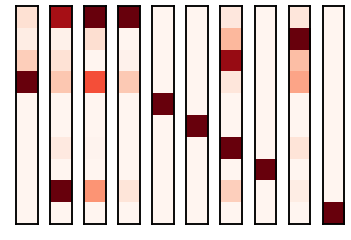

In [42]:
diffs = check_correlated_dimensions(imgs.to(current_device), model, current_device, perturb_value=2.0, perturb_mode='fixed')
visualize_perturbed_dims(diffs[0])

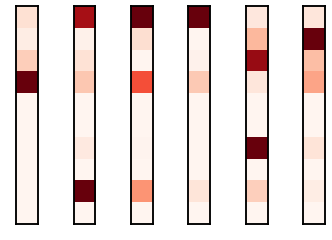

In [51]:
# 0-th index stores the squared differences
diff_np = diffs[0][0].cpu().numpy()

fig, axs = plt.subplots(1,6)
for i,r in enumerate([0,1,2,3,6,8]):
    axs[i].imshow(np.expand_dims(diff_np[r,:], axis=1), cmap='Reds')
    axs[i].set(yticklabels=[], yticks=[], xticks=[],xticklabels=[])

(10, 10)


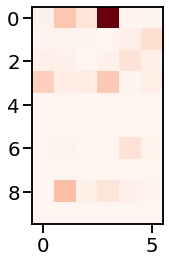

In [54]:
dim_perturbs = diffs[0][0].cpu().numpy().T
print(dim_perturbs.shape)
plt.imshow(dim_perturbs[:,[0,1,2,3,6,8]], cmap='Reds')

In [44]:
for i, t in enumerate(diffs[0][0]):
    print(i, t[i])

0 tensor(0.0242, device='cuda:0')
1 tensor(0.0069, device='cuda:0')
2 tensor(1.3612e-05, device='cuda:0')
3 tensor(0.2239, device='cuda:0')
4 tensor(4.0041, device='cuda:0')
5 tensor(3.9981, device='cuda:0')
6 tensor(0.1241, device='cuda:0')
7 tensor(3.9996, device='cuda:0')
8 tensor(0.0067, device='cuda:0')
9 tensor(3.9956, device='cuda:0')


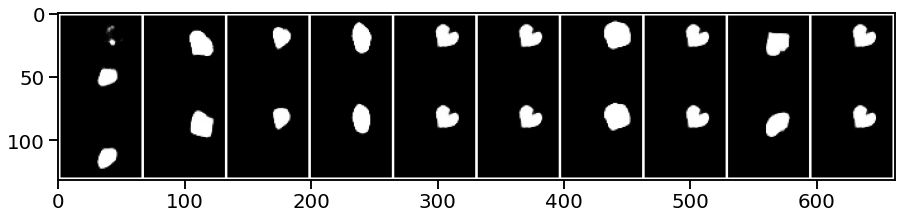

In [46]:

x_from_pmu, x_from_sec_pass = diffs[0][3], diffs[0][4]
sbs = torch.cat([x_from_pmu, x_from_sec_pass], dim = 2)
img_input_vs_recon = vutils.make_grid(sbs, normalize=True, value_range=(0.0,1.0), nrow=10, pad_value=1.0)

plt.figure(figsize=(15,20))
plt.imshow(img_input_vs_recon.cpu().permute(1,2,0).numpy())

In [38]:
x_from_pmu.shape, x_from_sec_pass.shape

(torch.Size([10, 1, 64, 64]), torch.Size([10, 1, 64, 64]))

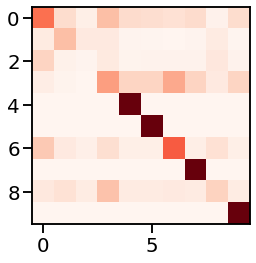

In [22]:
plt.imshow( torch.abs(diffs[0][1] - diffs[0][2]).cpu().numpy().T, cmap='Reds')

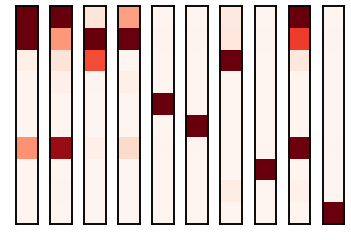

In [23]:
visualize_perturbed_dims(diffs[1])

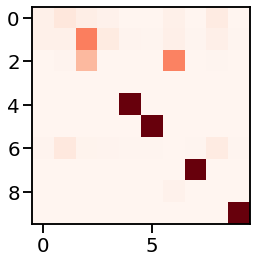

In [24]:
plt.imshow(diffs[1][0].cpu().numpy().T, cmap='Reds')

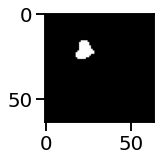

In [44]:
anchor_image = imgs[33]
fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(anchor_image.permute(1,2,0), cmap='gray')
anchor_image = anchor_image.unsqueeze(0).to(current_device)

In [45]:
#for i in range(10):
#    show_traversal_plot(model, anchor_image, limit=2, interp_step=1/5, dim=i, mode='relative')

Visualizing latent space from -3.12 to 2.98, with center at 3.05
Visualizing latent space from -3.93 to 2.17, with center at 3.05
Visualizing latent space from -3.45 to 2.65, with center at 3.05
Visualizing latent space from -3.77 to 2.33, with center at 3.05
Visualizing latent space from -3.44 to 2.66, with center at 3.05


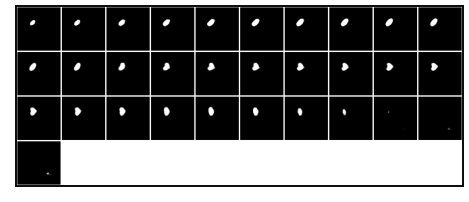

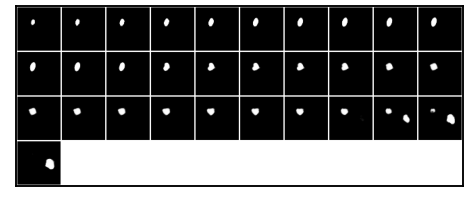

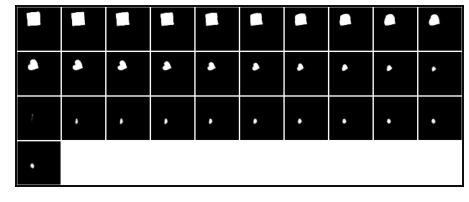

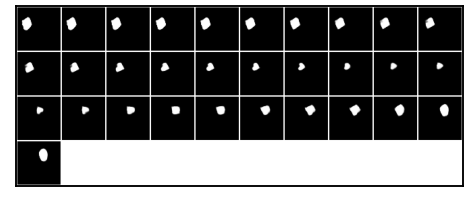

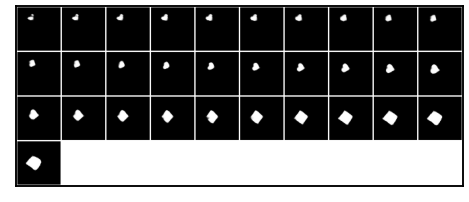

In [50]:
LIMIT = 3

show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=0, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=1, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=2, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=3, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=8, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))

Visualizing latent space from -3.12 to 2.98, with center at 3.05
Visualizing latent space from -3.93 to 2.17, with center at 3.05
Visualizing latent space from -3.45 to 2.65, with center at 3.05
Visualizing latent space from -3.77 to 2.33, with center at 3.05
Visualizing latent space from -3.44 to 2.66, with center at 3.05


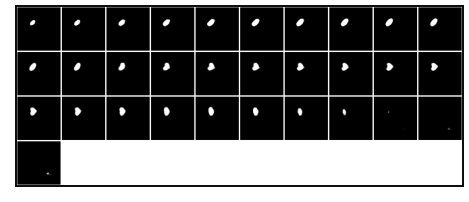

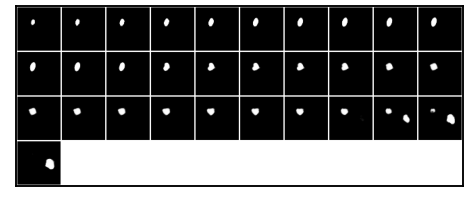

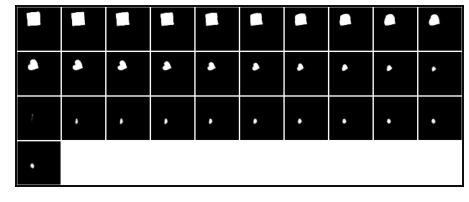

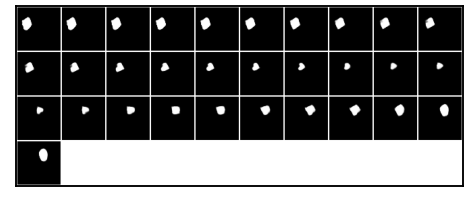

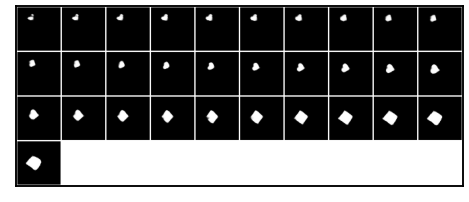

In [51]:
LIMIT = 3

show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=0,
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=1,
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=2,
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=3,
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=8,
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))

Visualizing latent space from -3.00 to 3.10, with center at 3.05
Visualizing latent space from -3.01 to 3.09, with center at 3.05
Visualizing latent space from -3.25 to 2.85, with center at 3.05
Visualizing latent space from -3.00 to 3.10, with center at 3.05
Visualizing latent space from -3.00 to 3.10, with center at 3.05


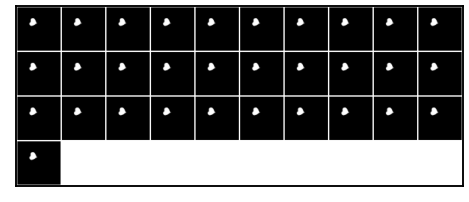

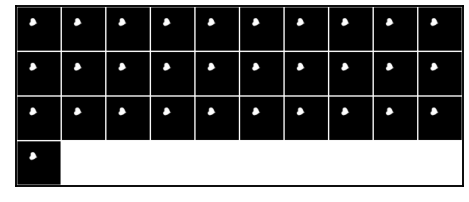

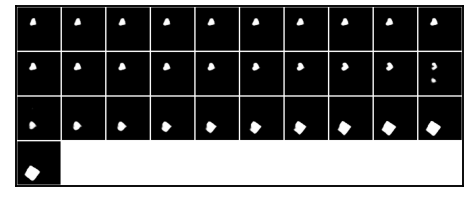

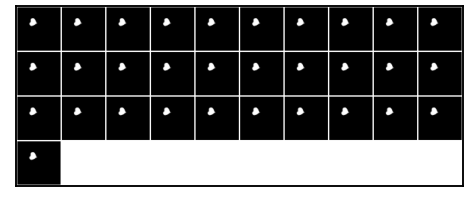

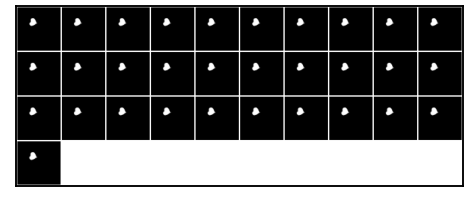

In [52]:
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=4, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=5, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=6, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=7, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=9, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))



Visualizing latent space from -3.00 to 3.10, with center at 3.05
Visualizing latent space from -3.01 to 3.09, with center at 3.05
Visualizing latent space from -3.25 to 2.85, with center at 3.05
Visualizing latent space from -3.00 to 3.10, with center at 3.05
Visualizing latent space from -3.00 to 3.10, with center at 3.05


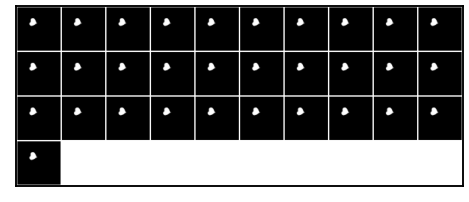

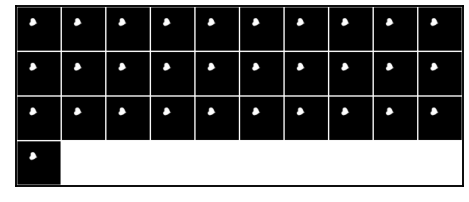

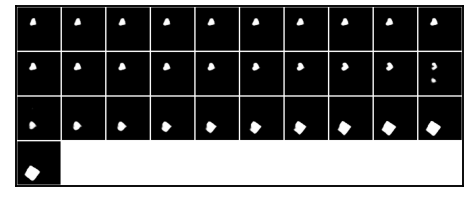

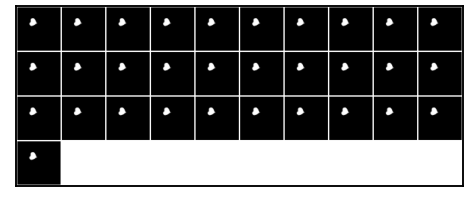

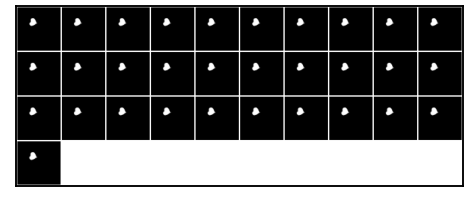

In [48]:
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=4, 
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=5, 
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=6, 
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=7, 
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=9,
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
